In [30]:
import math

from qiskit import QuantumRegister, QuantumCircuit
from qiskit import BasicAer
try:
    from qiskit.compiler import transpile
except ImportError:
    from qiskit.transpiler import transpile
import pyzx
from pyzx.circuit.qasmparser import QASMParser
from pyzx.circuit.qiskitqasmparser import QiskitQASMParser

In [44]:
"""Create quantum fourier transform circuit on quantum register qreg."""
n = 4 #hardcoded for now
qreg = QuantumRegister(n)
circuit = QuantumCircuit(qreg, name="qft")
n = len(qreg)
for i in range(n):
    for j in range(i):
        circuit.cu1(math.pi/float(2**(i-j)), qreg[i], qreg[j])
    circuit.h(qreg[i])

In [45]:
qc = circuit

In [46]:
qasm = qc.qasm()
### if you want to remove all barriers
## qasm = '\n'.join(['' if line.startswith("barrier") else line for line in qasm.splitlines()])

qc = qc.from_qasm_str(qasm)

print("\nPrint QASM:")
print(qasm)


Print QASM:
OPENQASM 2.0;
include "qelib1.inc";
qreg q3[4];
h q3[0];
cu1(1.57079632679490) q3[1],q3[0];
h q3[1];
cu1(0.785398163397448) q3[2],q3[0];
cu1(1.57079632679490) q3[2],q3[1];
h q3[2];
cu1(0.392699081698724) q3[3],q3[0];
cu1(0.785398163397448) q3[3],q3[1];
cu1(1.57079632679490) q3[3],q3[2];
h q3[3];



In [47]:
# Draw the circuit
print(qc)

         ┌───┐                                                         
q3_0: |0>┤ H ├─■──────■──────────────────■─────────────────────────────
         └───┘ │pi/2  │     ┌───┐        │                             
q3_1: |0>──────■──────┼─────┤ H ├─■──────┼──────■──────────────────────
                      │pi/4 └───┘ │pi/2  │      │     ┌───┐            
q3_2: |0>─────────────■───────────■──────┼──────┼─────┤ H ├─■──────────
                                         │pi/8  │pi/4 └───┘ │pi/2 ┌───┐
q3_3: |0>────────────────────────────────■──────■───────────■─────┤ H ├
                                                                  └───┘


In [48]:
p = QiskitQASMParser()
circ_list, whichpyzx = p.qiskitparse(qasm)
print(circ_list)
print(whichpyzx)
print(p.registers)

['qreg q3[4];', Circuit(4 qubits, 1 gates), 'cu1(1.57079632679490) q3[1],q3[0];', Circuit(4 qubits, 1 gates), 'cu1(0.785398163397448) q3[2],q3[0];', 'cu1(1.57079632679490) q3[2],q3[1];', Circuit(4 qubits, 1 gates), 'cu1(0.392699081698724) q3[3],q3[0];', 'cu1(0.785398163397448) q3[3],q3[1];', 'cu1(1.57079632679490) q3[3],q3[2];', Circuit(4 qubits, 1 gates)]
[1, 3, 6, 10]
{'q3': (0, 4)}


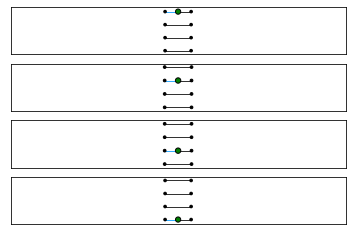

In [49]:
#qasm = qc.decompose().qasm()
pyzx.draw_many(circ_list, whichpyzx)

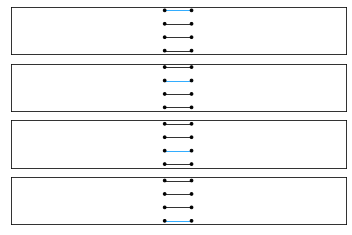

In [50]:
graph_list = [circ_list[w].to_graph() for w in whichpyzx]
[pyzx.full_reduce(g) for g in graph_list]
pyzx.draw_many(graph_list, range(len(whichpyzx)))

In [51]:
pyzx_circ_list = [pyzx.extract.streaming_extract(g) for g in graph_list]

for i in range(len(pyzx_circ_list)):
    prev = pyzx_circ_list[i]
    next = pyzx.extract.streaming_extract(graph_list[i])
    while prev.gates != next.gates:
        for j in range(len(next.gates))[::-1]:
            pyzx_circ_list[i].add_gate_to_front(next.gates[j])
        prev = next
        next = pyzx.extract.streaming_extract(graph_list[i])

pyzx_circ_list = [pyzx.optimize.basic_optimization(new_c.to_basic_gates()) for new_c in pyzx_circ_list]

pyzx_qasm = [new_c.to_basic_gates().to_qasm() for new_c in pyzx_circ_list]

passedAll = True
for i in range(len(pyzx_circ_list)):
    try:
        assert(pyzx.compare_tensors(pyzx_circ_list[i], circ_list[whichpyzx[i]]))
    except AssertionError:
        print(i)
        print(circ_list[whichpyzx[i]].__dict__)
        print(pyzx_circ_list[i].__dict__)
        passedAll = False
assert(passedAll)

In [52]:
pyzx_qasm = ["\n".join(['' if line.startswith("qreg") else line for line in circ.splitlines()[2:]]) for circ in pyzx_qasm]

for new_qasm in pyzx_qasm:
    [print(line) for line in new_qasm.splitlines()]
    print()


h q[0];


h q[1];


h q[2];


h q[3];



In [71]:
#now we need to map registers and glue all the pieces back together
for i in range(len(pyzx_qasm)):
    circ_list[whichpyzx[i]] = pyzx_qasm[i]
#print(circ_list)
## join the
qasm_string = 'OPENQASM 2.0;\ninclude "qelib1.inc";\n'+"\n".join(circ_list)
qasm_string = qasm_string.replace('q[', 'q3[') #why is this q3
print(qasm_string)

OPENQASM 2.0;
include "qelib1.inc";
qreg q3[4];

h q3[0];
cu1(1.57079632679490) q3[1],q3[0];

h q3[1];
cu1(0.785398163397448) q3[2],q3[0];
cu1(1.57079632679490) q3[2],q3[1];

h q3[2];
cu1(0.392699081698724) q3[3],q3[0];
cu1(0.785398163397448) q3[3],q3[1];
cu1(1.57079632679490) q3[3],q3[2];

h q3[3];


In [72]:
# pqsl = [line + "\n" for line in pyzx_qasm] #took out .splitlines()
# qsl = [line + "\n" for line in qasm.splitlines()]
# # print(pqsl)
# # print(qsl)
# new_qasm = '\n'.join(qsl[0:4]) + ''.join(pqsl[3:]) + ''.join(qsl[-2:])
# new_qasm = new_qasm.replace('q[', 'qr[')
# print(new_qasm)

In [73]:
new_qc = qc.from_qasm_str(qasm_string)
print(new_qc)

         ┌───┐                                                         
q3_0: |0>┤ H ├─■──────■──────────────────■─────────────────────────────
         └───┘ │pi/2  │     ┌───┐        │                             
q3_1: |0>──────■──────┼─────┤ H ├─■──────┼──────■──────────────────────
                      │pi/4 └───┘ │pi/2  │      │     ┌───┐            
q3_2: |0>─────────────■───────────■──────┼──────┼─────┤ H ├─■──────────
                                         │pi/8  │pi/4 └───┘ │pi/2 ┌───┐
q3_3: |0>────────────────────────────────■──────■───────────■─────┤ H ├
                                                                  └───┘


In [74]:
print(qc)

         ┌───┐                                                         
q3_0: |0>┤ H ├─■──────■──────────────────■─────────────────────────────
         └───┘ │pi/2  │     ┌───┐        │                             
q3_1: |0>──────■──────┼─────┤ H ├─■──────┼──────■──────────────────────
                      │pi/4 └───┘ │pi/2  │      │     ┌───┐            
q3_2: |0>─────────────■───────────■──────┼──────┼─────┤ H ├─■──────────
                                         │pi/8  │pi/4 └───┘ │pi/2 ┌───┐
q3_3: |0>────────────────────────────────■──────■───────────■─────┤ H ├
                                                                  └───┘


In [75]:
import qiskit
from qiskit.providers.basicaer import QasmSimulatorPy
c1 = qiskit.execute(qc, QasmSimulatorPy()).result().get_counts()
c2 = qiskit.execute(new_qc, QasmSimulatorPy()).result().get_counts()

No classical registers in circuit "circuit7", counts will be empty.
No classical registers in circuit "circuit10", counts will be empty.


In [76]:
c1
c2
assert(c1 == c2)

In [77]:
qiskit_transpiled_qc = qiskit.transpile(qc, basis_gates=['u3', 'cx'], optimization_level=2)

In [78]:
print(qiskit_transpiled_qc)

          ┌──────────┐ ┌───┐┌───────────┐┌───┐┌──────────┐┌───┐┌───────────┐»
q3_0: |0>─┤ U2(0,pi) ├─┤ X ├┤ U1(-pi/4) ├┤ X ├┤ U1(pi/4) ├┤ X ├┤ U1(-pi/8) ├»
          ├──────────┤ └─┬─┘└───────────┘└─┬─┘├──────────┤└─┬─┘└───────────┘»
q3_1: |0>─┤ U1(pi/4) ├───■─────────────────■──┤ U2(0,pi) ├──┼───────────────»
         ┌┴──────────┤                        └──────────┘  │               »
q3_2: |0>┤ U1(3pi/8) ├──────────────────────────────────────■───────────────»
         ├───────────┴┐                                                     »
q3_3: |0>┤ U1(1.3744) ├─────────────────────────────────────────────────────»
         └────────────┘                                                     »
«      ┌───┐┌──────────┐┌───┐             ┌────────────┐┌───┐            »
«q3_0: ┤ X ├┤ U1(pi/8) ├┤ X ├─────────────┤ U1(-pi/16) ├┤ X ├────────────»
«      └─┬─┘└──┬───┬───┘└─┬─┘┌───────────┐└───┬───┬────┘└─┬─┘┌──────────┐»
«q3_1: ──┼─────┤ X ├──────┼──┤ U1(-pi/4) ├────┤ X ├───────┼──┤ U1(pi/4) ├

In [79]:
pyzx_then_qiskit_qc = qiskit.transpile(new_qc, basis_gates=['u3', 'cx'], optimization_level=2)
print(pyzx_then_qiskit_qc)

          ┌──────────┐ ┌───┐┌───────────┐┌───┐┌──────────┐┌───┐┌───────────┐»
q3_0: |0>─┤ U2(0,pi) ├─┤ X ├┤ U1(-pi/4) ├┤ X ├┤ U1(pi/4) ├┤ X ├┤ U1(-pi/8) ├»
          ├──────────┤ └─┬─┘└───────────┘└─┬─┘├──────────┤└─┬─┘└───────────┘»
q3_1: |0>─┤ U1(pi/4) ├───■─────────────────■──┤ U2(0,pi) ├──┼───────────────»
         ┌┴──────────┤                        └──────────┘  │               »
q3_2: |0>┤ U1(3pi/8) ├──────────────────────────────────────■───────────────»
         ├───────────┴┐                                                     »
q3_3: |0>┤ U1(1.3744) ├─────────────────────────────────────────────────────»
         └────────────┘                                                     »
«      ┌───┐┌──────────┐┌───┐             ┌────────────┐┌───┐            »
«q3_0: ┤ X ├┤ U1(pi/8) ├┤ X ├─────────────┤ U1(-pi/16) ├┤ X ├────────────»
«      └─┬─┘└──┬───┬───┘└─┬─┘┌───────────┐└───┬───┬────┘└─┬─┘┌──────────┐»
«q3_1: ──┼─────┤ X ├──────┼──┤ U1(-pi/4) ├────┤ X ├───────┼──┤ U1(pi/4) ├

In [80]:
AllCircuits = {"QC_Original": qc, "QC_pyZX": new_qc, "QC_QiskitTranspiler": qiskit_transpiled_qc, "QC_Both": pyzx_then_qiskit_qc}
OutputDict = {}

if passedAll == False:
    print("reject this sample")
else:
    for key, value in AllCircuits.items():
        OutputDict[key]= {"Depth":value.depth(), "Size":value.size()}
    Metrics = ["Depth", "Size"]
print(OutputDict)


{'QC_Original': {'Depth': 7, 'Size': 10}, 'QC_pyZX': {'Depth': 7, 'Size': 10}, 'QC_QiskitTranspiler': {'Depth': 19, 'Size': 31}, 'QC_Both': {'Depth': 19, 'Size': 31}}


In [81]:
import numpy as np
import matplotlib.pyplot as plt

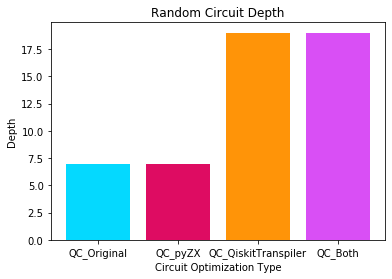

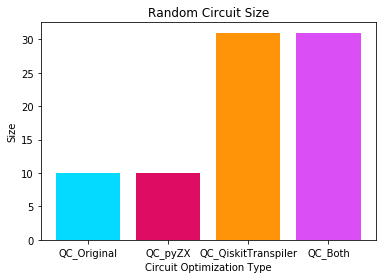

In [82]:
for metric in Metrics:
    plt.title("Random Circuit " + metric)
    plt.bar(range(len(AllCircuits)), [OutputDict[circ][metric] for circ in AllCircuits] , 
            align='center', color = ["xkcd:neon blue", "xkcd:cerise", "xkcd:tangerine", "xkcd:heliotrope"])
    plt.xticks(range(len(AllCircuits)), list(AllCircuits.keys()))
    plt.xlabel("Circuit Optimization Type")
    plt.ylabel(metric)
    plt.show()